**Group Project Report: Pulsar Star Classification**
===================

# Introduction

Pulsars or Pulse Stars are highly magnetized neutron stars that radiate radio-wave emissions of two opposing narrow beams of light that are spinning, which we perceive on earth as blinking (Cofield, 2016). Each pulsar star emits a different emission pattern that varies with each of its rotations, therefore whenever there is a signal detection, or “candidate”, it is averaged over several rotations of the pulse star (Lyon, 2017). Each of these candidates are potential descriptions of a real pulse star. Radio frequency interference and noise causes is responsible for most detections, the true pulse star signals are challenging to extract (Lyon, 2017).

Our data set includes pulsar candidate data. Using this data, we will attempt to predict which of these candidates are legitimate pulsar stars and which are not. Our question is thus: Can we differentiate legitimate pulsar stars from interference and noise using a classification model?

Our Data set can be found here: https://archive.ics.uci.edu/ml/datasets/HTRU2

This data set includes 9 variables (9 columns), and approximately 18000 rows. 

| Variables |  Definitions |
|----------------|------------|
| <p align="left">Mean IP| <p align="left">Mean of the integrated profile 
|
| <p align="left">Standard deviation IP| <p align="left">Standard deviation of the integrated profile|
 | <p align="left">Excess kurtosis IP| <p align="left">Excess kurtosis of the integrated profile|
| <p align="left">Skewness IP| <p align="left">Skewness of the integrated profile|
 | <p align="left">Mean DM-SNR curve| <p align="left">Mean of the Dispersion Measure - Signal to noise ratio curve|
| <p align="left">Standard deviation DM-SNR curve| <p align="left">Standard deviation of the Dispersion Measure - Signal to noise ratio curve|
| <p align="left">Excess kurtosis DM-SNR curve| <p align="left">Excess kurtosis of the Dispersion Measure - Signal to noise ratio curve|
| <p align="left">Skewness DM-SNR curve|  <p align="left">Skewness of the of the Dispersion Measure - Signal to noise ratio curve|
| <p align="left">Class | <p align="left">Whether or not an observation is a pulsar star or not. If Class = 0, the observation is not a pulsar star, while if Class = 1, the observation is a pulsar star.|

**Table 1** Pulsar star dataset variables and definitions.
**The integrated profile variables refer to a method used to describe the radiation pulsar stars emit.**

The integrated profile variables refer to a method used to describe the radiation pulsar stars emit.
    Individual pulses vary in shape, and their radiation is detected as individual photons which arrive infrequently (Lyne & Graham Smith, 2012). The timing of the pulse’s arrival also varies across different radio frequencies. The delay between frequencies is known as dispersion (Krishnan, 2020). 
    
DM-SNR, or Dispersion Measure - Signal to noise ratio curves are created to adjust for the effect of these frequency delays (Krishnan, 2020). The variables 1-8 in this dataset thus describe the mean, skewness, standard deviation, and excess kurtosis of the integrated profile and DM-SNR curves. The Class variable refers to whether or not an observation is a pulsar star or not. 0 = the observation is not a pulsar star,  1 = the observation is a pulsar star.

    

# Methods and Results

## Preliminary Exploratory Data Analysis

In [1]:
## install packages
#install.packages("tidyverse")
#install.packages("repr")
#install.packages("tidymodels")
#install.packages("cowplot")

In [2]:
## RUN THIS CELL BEFORE CONTINUING 
#Note: if the packages not installed, uncomment the previous cell and run it
## load packages
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Loading data from the web

In [3]:
#link to the zip file we want to download
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"

#Create temporary file to store zip file and download zip file
temp <- tempfile()
download.file(url, temp)

#read dataset (HTRU_2.csv) from zip file (temp) + give each column appropriate name
pulsar_data <- read_csv(unz(temp, "HTRU_2.csv"), col_names = c("Mean IP", 
                                                         "Standard deviation IP", 
                                                         "Excess kurtosis IP", 
                                                         "Skewness IP",
                                                         "Mean DM-SNR curve",
                                                         "Standard deviation DM-SNR curve",
                                                         "Excess kurtosis DM-SNR curve",
                                                         "Skewness DM-SNR curve",
                                                         "Class"))
#Note: IP = Integrated Profile

#delete temporary file (because no longer needed)
unlink(temp)

#display the first 6 rows of our dataset
head(pulsar_data)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean IP, Standard deviation IP, Excess kurtosis IP, Skewness IP, Me...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean IP,Standard deviation IP,Excess kurtosis IP,Skewness IP,Mean DM-SNR curve,Standard deviation DM-SNR curve,Excess kurtosis DM-SNR curve,Skewness DM-SNR curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


**Table 2** First 6 rows of the raw pulsar star data.

### Cleaning & Wrangling data into a tidy format

In [4]:
# make the class column (that determines whether an observation is a pulsar or not) as a factor
pulsar_data <- pulsar_data |> 
        mutate(Class = as_factor(Class))

#replace spaces in column names by dots
colnames(pulsar_data) = make.names(colnames(pulsar_data))

#display the first 6 rows of our now tidy dataset
head(pulsar_data)

Mean.IP,Standard.deviation.IP,Excess.kurtosis.IP,Skewness.IP,Mean.DM.SNR.curve,Standard.deviation.DM.SNR.curve,Excess.kurtosis.DM.SNR.curve,Skewness.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


**Table 3** First 6 rows of the raw pulsar star data, with amended names.

### Exploratory data analysis

In [5]:
#DO NOT CHANGE THIS (this seed value will makes our results reproductible)
set.seed(1)

# splitting data into training and testing data
pulsar_split <- initial_split(pulsar_data, prop = .75, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

## Summarize training data: 

# 1. dimensions of training data
pulsar_train_dimensions <- pulsar_train |>
        dim()
pulsar_train_dimensions

[1] 13423     9

In [6]:
# 2. number and proportion of observations in each class type
pulsar_train_summary <- pulsar_train |> 
  group_by(Class) |> 
  summarize(n = n(),
            proportion = n()/13423) #ref. to dimentions above (nb of rows corresponds to nb of observations)

pulsar_train_summary

Class,n,proportion
<fct>,<int>,<dbl>
0,12200,0.90888773
1,1223,0.09111227


**Table 4** Summary of the number and proportions of observations of each class in the training dataset. 

In [7]:
# 3. means of the predictor variables
pulsar_predictor_means <- pulsar_train |> 
  select(-Class) |> 
  summarize(across(everything(), mean))

pulsar_predictor_means

Mean.IP,Standard.deviation.IP,Excess.kurtosis.IP,Skewness.IP,Mean.DM.SNR.curve,Standard.deviation.DM.SNR.curve,Excess.kurtosis.DM.SNR.curve,Skewness.DM.SNR.curve
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111.1363,46.56378,0.4749385,1.757917,12.47593,26.29282,8.305187,104.6209


**Table 5** Means of the potential predictive variables in the training data set.

In [8]:
# 4. number of rows with missing data

pulsar_missing_data <- pulsar_train |> 
    filter_at(pulsar_train |> colnames() |> all_of() |> vars(), any_vars(is.na(.)))

number_of_rows_missing <- nrow(pulsar_missing_data)
number_of_rows_missing  # there are no missing data in this dataset

[1] 0

## Exploratory data visualization

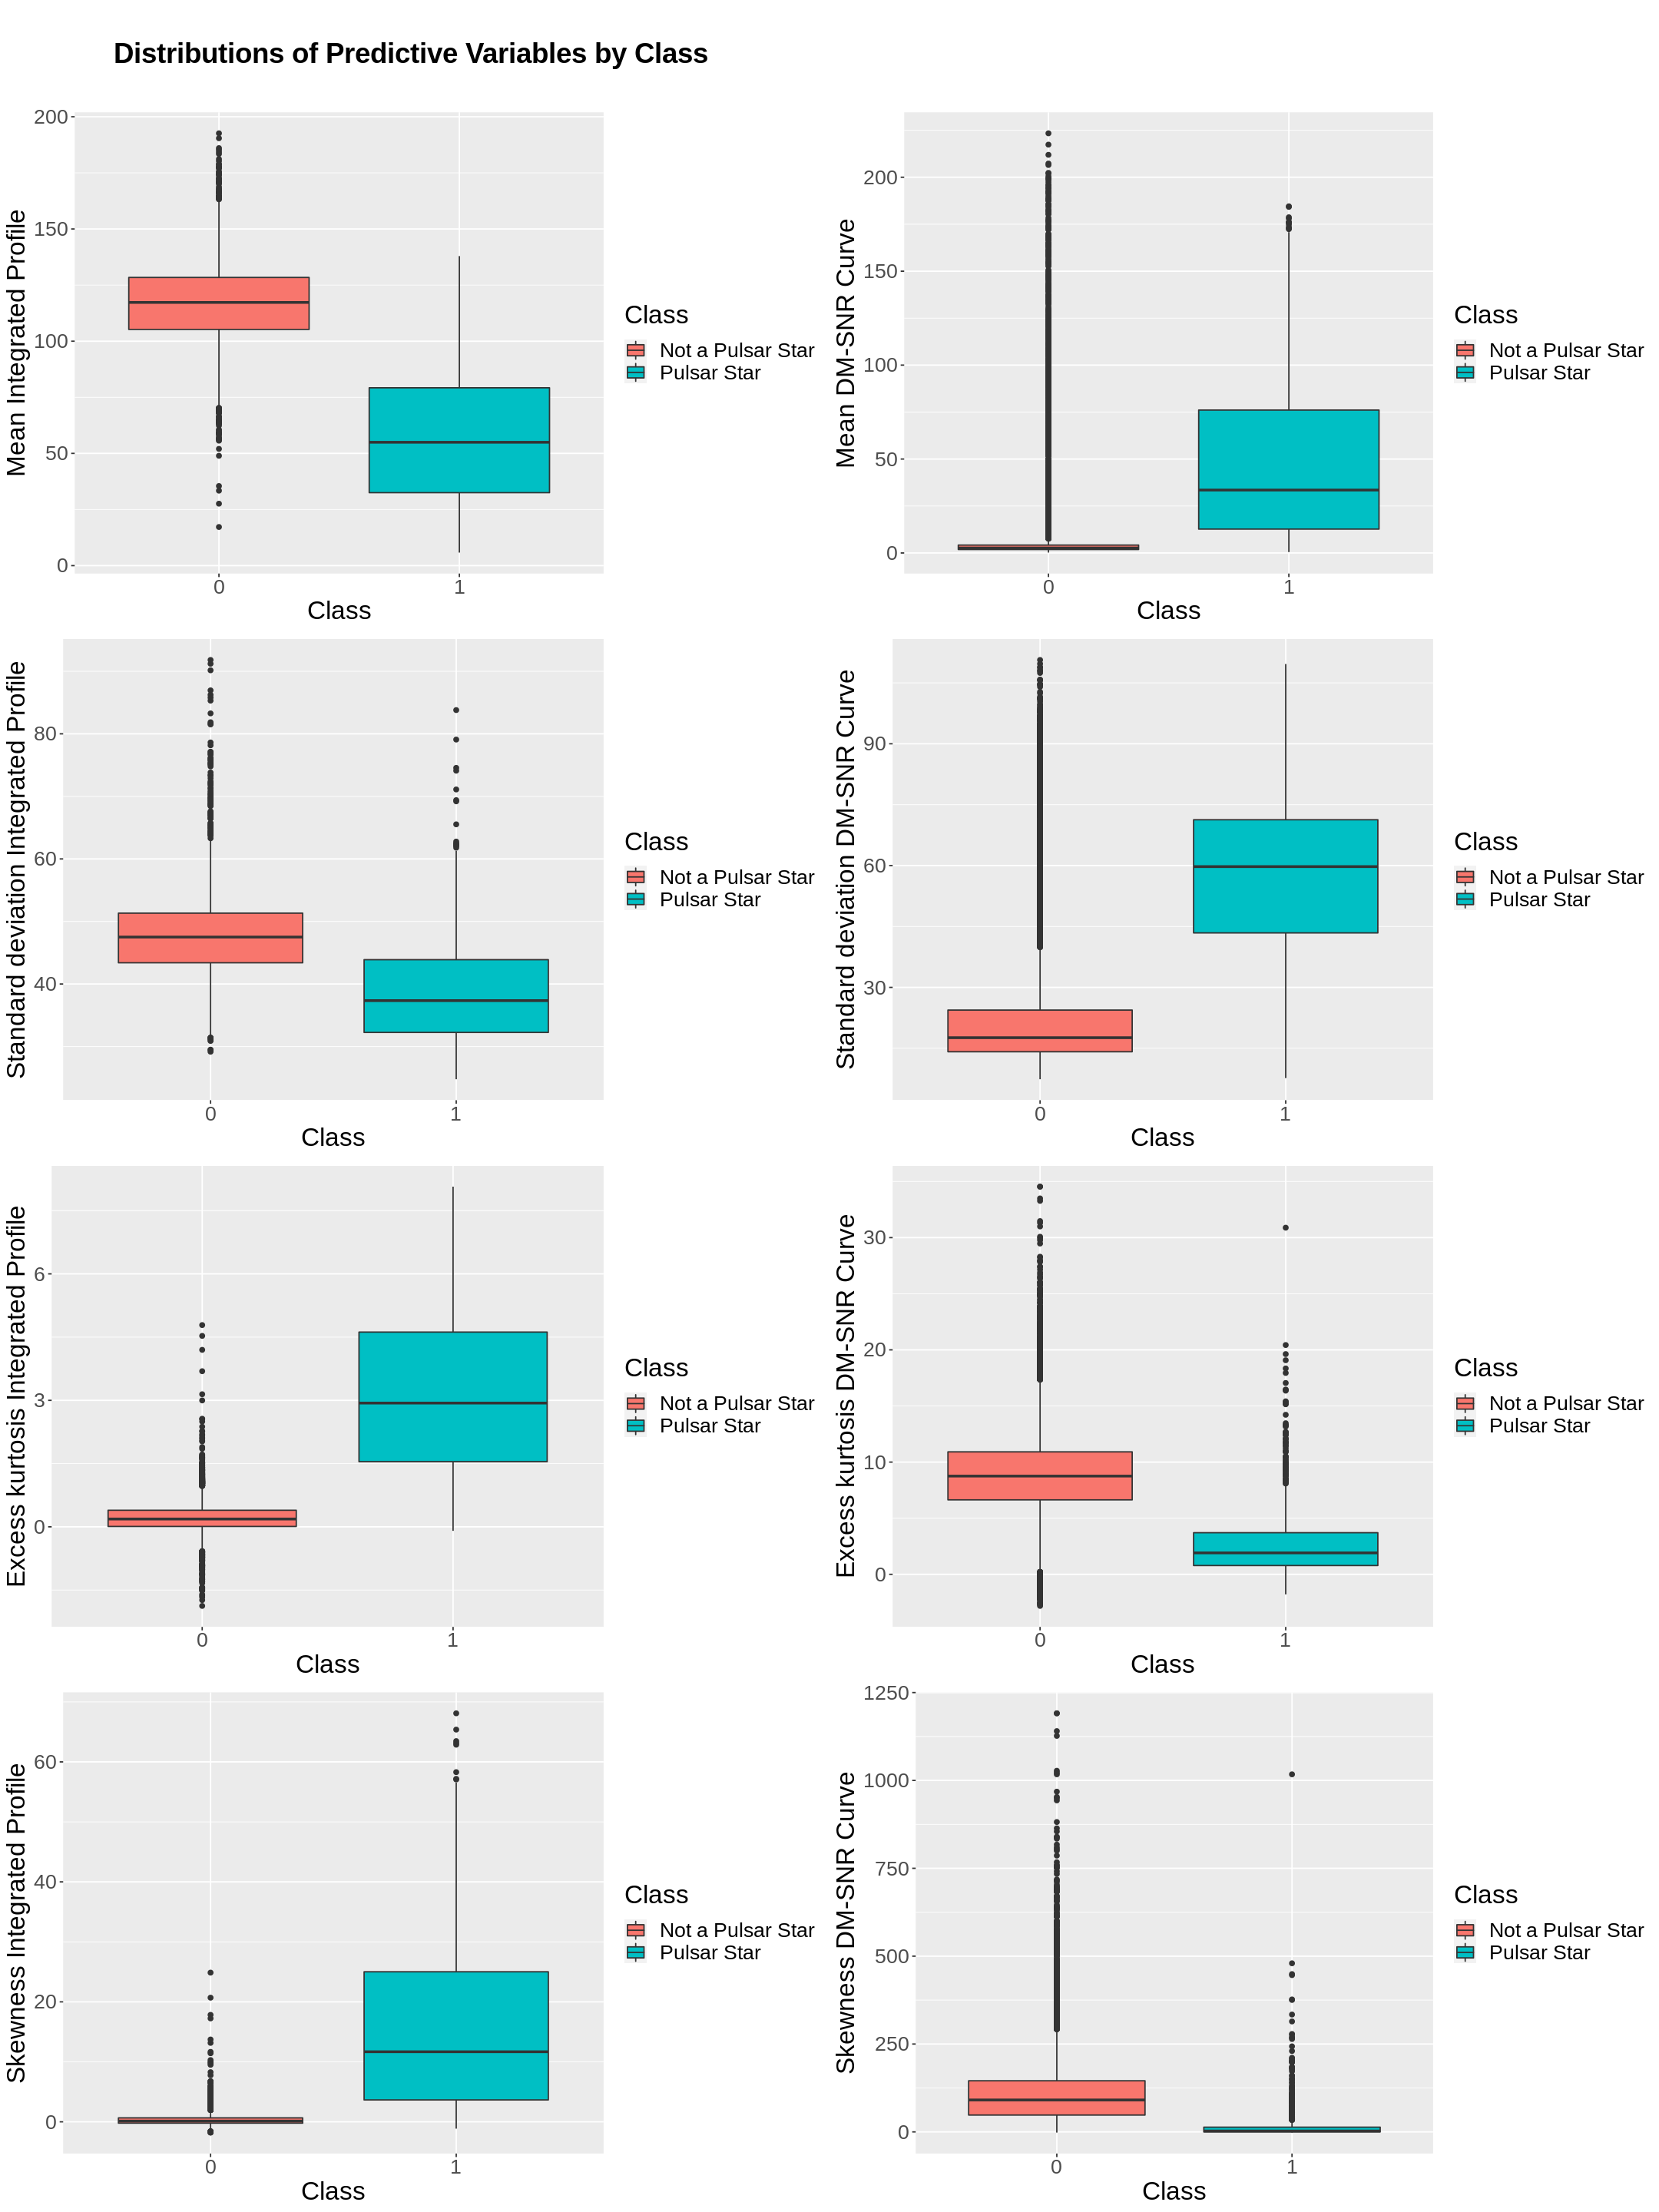

In [9]:
# these boxplots show the distribution of observations for each variable and how that relates to the Class of the observation
pulsar_boxplot_IPmean <- pulsar_train |> 
      ggplot(aes(x = Mean.IP, y = Class, fill = Class))+
      geom_boxplot()+
      labs( x = "Mean Integrated Profile" ,
            y =  "Class") + 
      coord_flip()+ 
      scale_fill_discrete(labels = c( "Not a Pulsar Star", "Pulsar Star"))+
      theme(text = element_text(size = 20))

pulsar_boxplot_DMSNRmean <- pulsar_train |> 
      ggplot(aes(x = Mean.DM.SNR.curve, y = Class, fill = Class))+
      geom_boxplot()+
      labs( x = "Mean DM-SNR Curve" ,
            y =  "Class") + 
      coord_flip()+ 
      scale_fill_discrete(labels = c( "Not a Pulsar Star", "Pulsar Star"))+
      theme(text = element_text(size = 20))

pulsar_boxplot_SDIP <- pulsar_train |> 
      ggplot(aes(x = Standard.deviation.IP, y = Class, fill = Class))+
      geom_boxplot()+
      labs( x = "Standard deviation Integrated Profile" ,
            y =  "Class") + 
      coord_flip()+ 
      scale_fill_discrete(labels = c( "Not a Pulsar Star", "Pulsar Star"))+
      theme(text = element_text(size = 20))

pulsar_boxplot_SD_DMSNR <- pulsar_train |> 
      ggplot(aes(x = Standard.deviation.DM.SNR.curve, y = Class, fill = Class))+
      geom_boxplot()+
      labs( x = "Standard deviation DM-SNR Curve" ,
            y =  "Class") + 
      coord_flip()+ 
      scale_fill_discrete(labels = c( "Not a Pulsar Star", "Pulsar Star"))+
      theme(text = element_text(size = 20))

pulsar_boxplot_exkur_IP <- pulsar_train |> 
      ggplot(aes(x =Excess.kurtosis.IP , y = Class, fill = Class))+
      geom_boxplot()+
      labs( x = "Excess kurtosis Integrated Profile" ,
            y =  "Class") + 
      coord_flip()+ 
      scale_fill_discrete(labels = c( "Not a Pulsar Star", "Pulsar Star"))+
      theme(text = element_text(size = 20))

pulsar_boxplot_exkur_DMSNR <- pulsar_train |> 
      ggplot(aes(x = Excess.kurtosis.DM.SNR.curve , y = Class, fill = Class))+
      geom_boxplot()+
      labs( x = "Excess kurtosis DM-SNR Curve" ,
            y =  "Class") + 
      coord_flip()+ 
      scale_fill_discrete(labels = c( "Not a Pulsar Star", "Pulsar Star"))+
      theme(text = element_text(size = 20))

pulsar_boxplot_skew_IP <- pulsar_train |> 
      ggplot(aes(x = Skewness.IP, y = Class, fill = Class))+
      geom_boxplot()+
      labs( x = "Skewness Integrated Profile" ,
            y =  "Class") + 
      coord_flip()+ 
      scale_fill_discrete(labels = c( "Not a Pulsar Star", "Pulsar Star"))+
      theme(text = element_text(size = 20))

pulsar_boxplot_skew_DMSNR <- pulsar_train |> 
      ggplot(aes(x = Skewness.DM.SNR.curve, y = Class, fill = Class))+
      geom_boxplot()+
      labs( x = "Skewness DM-SNR Curve" ,
            y =  "Class") + 
      coord_flip()+ 
      scale_fill_discrete(labels = c( "Not a Pulsar Star", "Pulsar Star"))+
      theme(text = element_text(size = 20))

options(repr.plot.width=18, repr.plot.height=24)

title <- ggdraw() + draw_label("Distributions of Predictive Variables by Class ", fontface='bold', size = 22) # adds a title to the plotgrid

plot_grid(title, NULL, pulsar_boxplot_IPmean, pulsar_boxplot_DMSNRmean, pulsar_boxplot_SDIP, pulsar_boxplot_SD_DMSNR,
          pulsar_boxplot_exkur_IP, pulsar_boxplot_exkur_DMSNR, pulsar_boxplot_skew_IP, pulsar_boxplot_skew_DMSNR, ncol = 2, rel_heights = c(.2,1,1,1,1))



**Figure 1** Boxplots of potential predictive variables plotted by class.

These 8 plots compare the distributions of observations between means, standard deviation, excess kurtosis and skewness of the DM-SNR profiles and Integrated Profiles across the 2 Classes. For all 8 plots, the potential predictive variable is correlated with Class, although this relationship is weaker for the skewness of the DM-SNR and Integrated Profile variables. However, the difference in medians is most significant for the Mean Integrated Profile, Standard deviation DM-SNR Curve, Excess kurtosis Integrated Profile variables and thus these will be used as our predictive variables. Many of the variables have a large number of outliers, and smaller differences between median values, and were thus not used as predictive variables.

## Data analysis
### K Nearest Neighbors Classification

 In order to perform our analysis, we used the mean integrated profile, excess kurtosis of the integrated profile, and standard deviation DM-SNR Curve variables as predictive variables. As discussed in the exploratory data analysis, **these 3 variables show a clear relationship between their value and the Class of the observation**, while the other variables show a weaker relationship. 
 
 In order to perform our analysis, we **split the data into training and testing data** as shown in the exploratory analysis section. This step was important to ensure our model did not "see" the testing data during training, as this would result in an erroneously high accuracy value. We then used **K- Nearest Neighbors Classification** to create a model which classifies our testing data as a pulsar star or not.  We created a model using our predictive variables and used a **5-fold cross-validation technique** to determine the K value that gives us the greatest predictive accuracy. Finally, we **re-trained our model** with the K-value obtained from the cross-validation process and **evaluated our model** using the testing data.  
 
 We used K-NN Classification because our question revolved around whether or not a given observation was a pulsar star or not. Because our question involves determining the category of an observation, rather than predicting a numerical value, classification was a more appropriate technique than regression. 



In [10]:
# create KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

# create a recipe
recipe <- recipe(Class ~ Mean.IP+Standard.deviation.DM.SNR.curve+Excess.kurtosis.IP , data = pulsar_train) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())


In [11]:
# 5 fold cross-validation
vfold_train <- vfold_cv(pulsar_train, v = 5, strata = Class)

In [12]:
# fit and tune the model to test different values of k
pulsar_fit <- workflow() |> 
    add_recipe(recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = vfold_train, grid = 10) |>
    collect_metrics()

#pull the k value with the highest accuracy for use in the final model
kmin <- pulsar_fit |>
        filter(.metric == "accuracy") |>
        filter(mean == max(mean)) |>
        select(neighbors) |>
        tail(1)|>
        pull()
kmin

[1] 14

k = 14 had the highest accuracy and thus was used in the final model training.

In [13]:
## re-train model with k-value obtained from cross-validation

# create KNN model
knn_spec2 <-nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
        set_engine("kknn") |>
        set_mode("classification")

#fit the model 
pulsar_fit2 <- workflow() |> 
    add_recipe(recipe) |>
    add_model(knn_spec2) |>
    fit(data = pulsar_train)


In [14]:
## evaluate model using testing data
pulsar_predictions <- predict(pulsar_fit2 , pulsar_test) |>
    bind_cols(pulsar_test) |>
    select(.pred_class, Class)

head(pulsar_predictions)
print("Table 6: First 6 rows of pulsar prediction results")

# pull the accuracy metrics 
pulsar_metrics <- pulsar_predictions |>
  metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

pulsar_metrics

# create a confusion matrix
pulsar_conf_mat <-pulsar_predictions |>
    conf_mat(truth = Class , estimate = .pred_class)

pulsar_conf_mat


.pred_class,Class
<fct>,<fct>
0,0
0,0
0,0
0,0
0,0
0,0


[1] "Table 6: First 6 rows of pulsar prediction results"


[1] 0.9801117

          Truth
Prediction    0    1
         0 4034   64
         1   25  352

**Table 7**: Confusion  Matrix of pulsar prediction results. 

Our model has an accuracy value of 98.01%, which is very good. The confusion matrix summarizes correct and incorrect predictions made by the model. The model correctly predicted 4034 observations as non-pulsar stars and 352 observations as pulsar stars. The model incorrectly predicted 64 observations as pulsar stars, although they were actually not pulsar stars. It also incorrectly classified 25 pulsar star observations as non-pulsar stars.

### Visualization of the data analysis

As discussed in the data analysis, our model uses **three prediction variables**. This means that our visualization of the model has to **reflect each of their contribution to the predictions, without using 3D visualizations** -- as they are ineffective in this case. To do so, we will create **three colored prediction map visualizations** (in 2D) that will reflect each combination of the three prediction variables. This visualization method consists in the creation of a synthetic "grid" of observations, that is then predicted and plotted under the pulsar data. This will allow us to visualize **how the model predicts values** (for two of the tree prediction variables), and **how that compares to the pulsar data points**. For our particular case, since our Class only has two values (0: not pulsar, 1: pulsar), the three prediction map visualizations will **show us where the data points' predictions are "separated" when looking at two predictors**. 

Another way to think about this is that our three visualizations will be 2D cutouts/point of views of how our 3D model predics the pulsar data, with a top-down perspective and two side perspectives. 

In [15]:
# For each variable, create 3 vectors that have 60 values, from the minimum to the maximum value of that variable
mean.ip_grid <- seq(min(pulsar_train$Mean.IP), 
                    max(pulsar_train$Mean.IP),
                    length.out = 60)

sd.dmsnr_grid <- seq(min(pulsar_train$Standard.deviation.DM.SNR.curve), 
                     max(pulsar_train$Standard.deviation.DM.SNR.curve),
                     length.out = 60)

ek.ip_grid <- seq(min(pulsar_train$Excess.kurtosis.IP), 
                  max(pulsar_train$Excess.kurtosis.IP),
                  length.out = 60)

# Create a database of all the possible combinations of the three vectors; this represents a 3D grid of size 60x60x60 (= 180,000 observations)
grid <- as_tibble(expand.grid(Mean.IP = mean.ip_grid,
                              Standard.deviation.DM.SNR.curve = sd.dmsnr_grid,
                              Excess.kurtosis.IP = ek.ip_grid))

In [16]:
# predict each observation of the grid; will help us visualize the model's behavior
predict_grid <- pulsar_fit2 |>
        predict(grid) |>
        bind_cols(grid) |>
        rename(Class = .pred_class)

In [17]:
# Create a function called "get_mode" that produces the statistical mode of a variable (here, it will be used for Class) 
get_mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

# Data tidying for each pair of variable: abstraction of the unwanted variable to keep the two variables of interest. Done replacing the Class by its mode.

    # Mean IP & Standard Deviation DM DNR curve
m_vs_sd <- predict_grid |>
        group_by(Mean.IP,Standard.deviation.DM.SNR.curve) |>
        summarize(Class_mode = get_mode(Class),
                  Mean.IP = unique(Mean.IP),
                  Standard.deviation.DM.SNR.curve = unique(Standard.deviation.DM.SNR.curve))

    # Excess kurtosis IP & Standard Deviation DM DNR curve
ek_vs_sd <- predict_grid |>
        group_by(Excess.kurtosis.IP,Standard.deviation.DM.SNR.curve) |>
        summarize(Class_mode = get_mode(Class),
                  Excess.kurtosis.IP = unique(Excess.kurtosis.IP),
                  Standard.deviation.DM.SNR.curve = unique(Standard.deviation.DM.SNR.curve))

    # Mean IP & Excess kurtosis IP
m_vs_ek <- predict_grid |>
        group_by(Mean.IP,Excess.kurtosis.IP) |>
        summarize(Class_mode = get_mode(Class),
                  Mean.IP = unique(Mean.IP),
                  Excess.kurtosis.IP = unique(Excess.kurtosis.IP))

`summarise()` has grouped output by 'Mean.IP'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Excess.kurtosis.IP'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Mean.IP'. You can override using the
`.groups` argument.


Warning message in as_grob.default(plot):
“Cannot convert object of class numeric into a grob.”


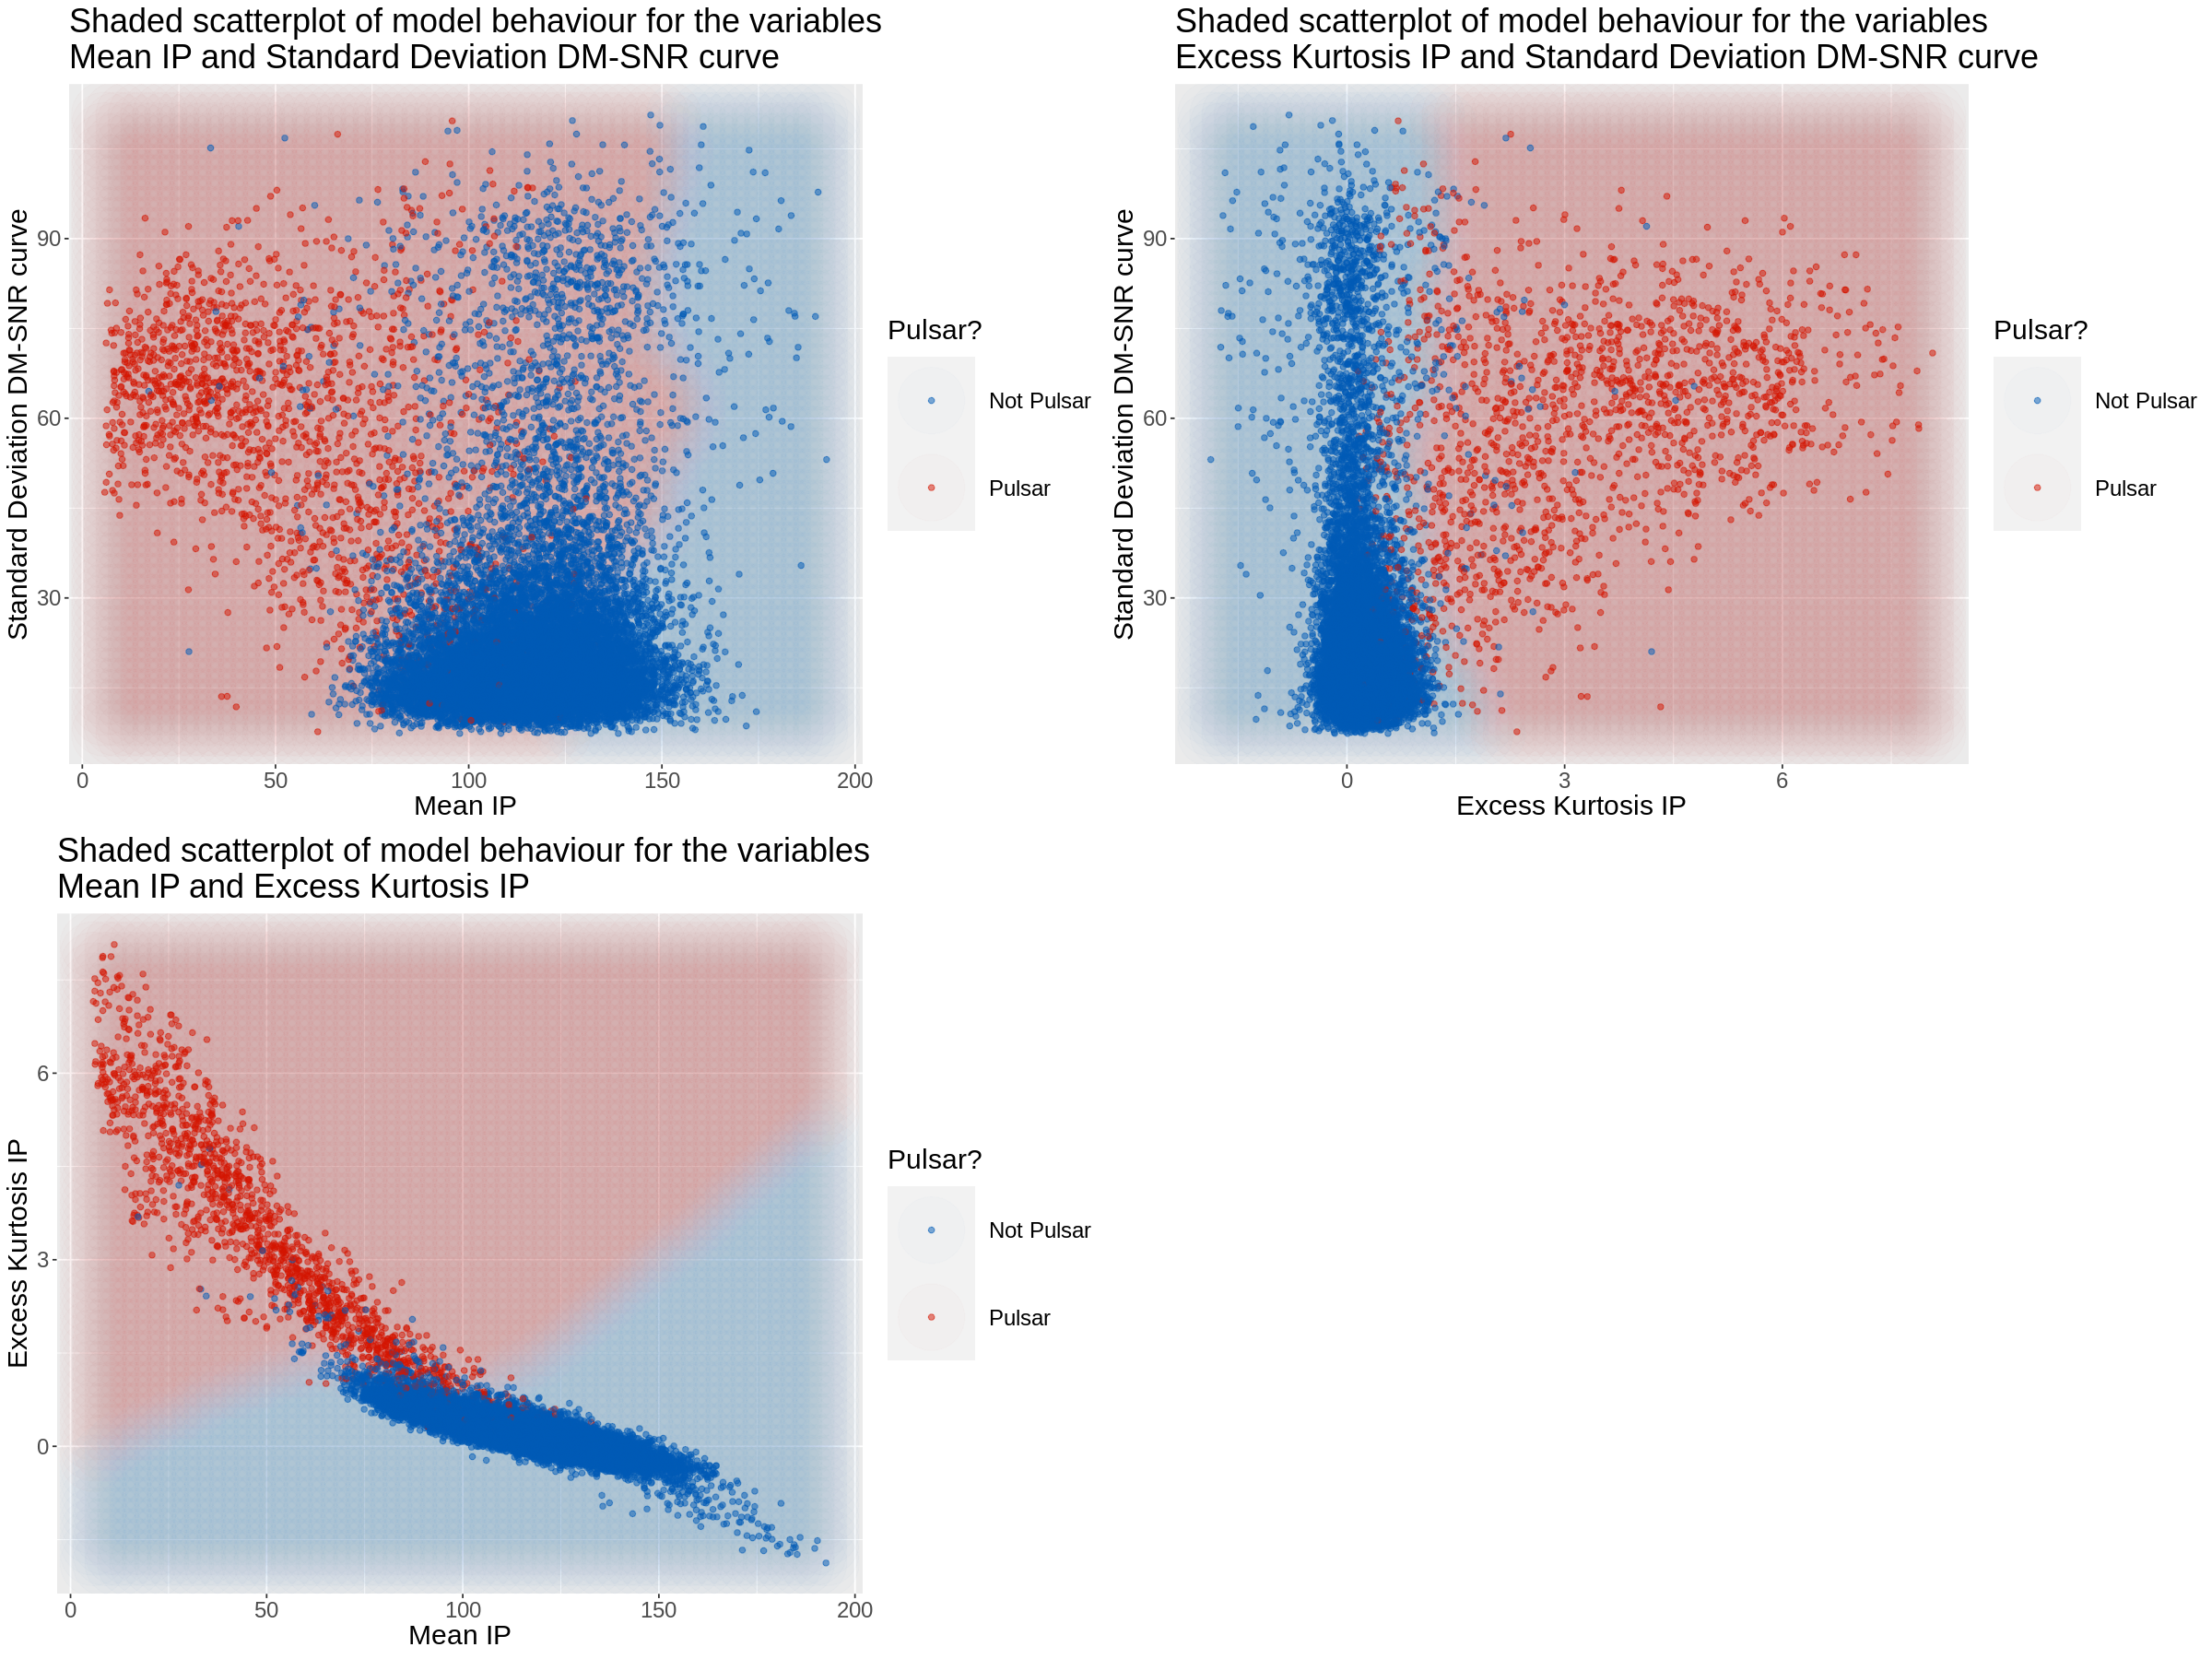

In [18]:
options(repr.plot.width = 10, repr.plot.height = 10)

# Creation of plots for each variable pair by overlaying the data over the predicted grid points; This allows us to see the model's behavior for all values.

    # Mean IP & Standard Deviation DM DNR curve
m_vs_sd_plot <- ggplot() +
        geom_point(data = m_vs_sd,
                  mapping = aes(x = Mean.IP,
                                y = Standard.deviation.DM.SNR.curve,
                                color = Class_mode),
                                alpha = .01,
                                size = 20) +
        geom_point(data = pulsar_data,
                   mapping = aes(x = Mean.IP,
                                 y = Standard.deviation.DM.SNR.curve,
                                 color = Class),
                                 alpha = .5) +
        labs(color = "Class", x = "Mean IP", y = "Standard Deviation DM-SNR curve", title = "Shaded scatterplot of model behaviour for the variables \nMean IP and Standard Deviation DM-SNR curve") +
        scale_color_manual(labels = c("Not Pulsar", "Pulsar"), 
                     values = c("#005AB5", "#D41400")) +       #Colorblind friendly colors (source: https://davidmathlogic.com/colorblind/#%23994F00-%23006CD1)
        theme(text = element_text(size = 18))

    # Excess kurtosis IP & Standard Deviation DM DNR curve
ek_vs_sd_plot <- ggplot() +
        geom_point(data = ek_vs_sd,
                  mapping = aes(x = Excess.kurtosis.IP,
                                y = Standard.deviation.DM.SNR.curve,
                                color = Class_mode),
                                alpha = .01,
                                size = 20) +
        geom_point(data = pulsar_data,
                   mapping = aes(x = Excess.kurtosis.IP,
                                 y = Standard.deviation.DM.SNR.curve,
                                 color = Class),
                                 alpha = .5) +
        labs(color = "Class", x = "Excess Kurtosis IP", y = "Standard Deviation DM-SNR curve", title = "Shaded scatterplot of model behaviour for the variables \nExcess Kurtosis IP and Standard Deviation DM-SNR curve") +
        scale_color_manual(labels = c("Not Pulsar", "Pulsar"), 
                     values = c("#005AB5", "#D41400")) +       #Colorblind friendly colors (source: https://davidmathlogic.com/colorblind/#%23994F00-%23006CD1)
        theme(text = element_text(size = 18))

    #Mean IP & Excess kurtosis IP
m_vs_ek_plot <- ggplot() +
        geom_point(data = m_vs_ek,
                  mapping = aes(x = Mean.IP,
                                y = Excess.kurtosis.IP,
                                color = Class_mode),
                                alpha = .01,
                                size = 20) +
        geom_point(data = pulsar_data,
                   mapping = aes(x = Mean.IP,
                                 y = Excess.kurtosis.IP,
                                 color = Class),
                                 alpha = .5) +
        labs(color = "Class", x = "Mean IP", y = "Excess Kurtosis IP", title = "Shaded scatterplot of model behaviour for the variables \nMean IP and Excess Kurtosis IP") +
        scale_color_manual(labels = c("Not Pulsar", "Pulsar"), 
                     values = c("#005AB5", "#D41400")) +       #Colorblind friendly colors (source: https://davidmathlogic.com/colorblind/#%23994F00-%23006CD1)
        theme(text = element_text(size = 18))

options(repr.plot.width = 20, repr.plot.height = 15)
plot_grid(m_vs_sd_plot, ek_vs_sd_plot, m_vs_ek_plot, ncols = 3)

**Figure 2** colored prediction map visualizations of each combination of the three prediction variables are plotted by Class. 

As described at the beginning of this section, **our three colored prediction map visualizations show how the model separates observations that are classified pulsar and those that are classified not pulsar**, depending on two variables. This is **shown by the colored shaded areas** (blue is not pulsar prediction, red is pulsar prediction). 

To come back to our explanation of how this represents a 3D visualization, if we were to print the three visualizations and combine them in a way where each variable occupies one axis, we would get a really good idea of how our model predicts the data in 3 dimensions (it would be 3D because there would be 3 axes).

# Discussion

Our analysis determined that we could predict whether an observation was a pulsar star or not with 98.01% accuracy, which is very high. In fact, the majority classifier (always guesses the majoritiy Class, here 0) would have an accuracy of 90.89% accuracy, since that is the proportion non pulsar observations (Class 0) in the training data (ref. Exploratory Data Analysis - 2.). This suggests our model is very good, and that the predictive variables we used are strong predictive variables. We expected that K-NN Classification would be a useful method for determining if an observation is a pulsar star or not, in part because it requires few assumptions about what the data looks like. However, we did not expect our accuracy to be so high. This is potentially due to the large size of the dataset used; there were 13,423 observations in our training set. The high accuracy could also be due to the fact that all of the predictive variables are derived from direct measurements of emissions from the objects in space; as such, they are likely to be better predictors. Other datasets, such as those on cancer in humans, are likely to have predictive variables which may be confounding variables, and predictive variables which may not be as strongly linked to the Class of the observation. 

Our findings could be impactful because if a model is sufficiently accurate at predicting the class of an observation, then a model such as ours could be used in place of all-sky surveys, a method for using a telescope to find pulsar stars (Cofield, 2016). This would significantly reduce the effort required to identify pulsar stars.

We expect that future potential questions might include the following:
- Do more optimal configurations of predictive variables than we used in our analysis exist, and if so, what are they?
- What are alternative ways we can predict the class of observations from potential pulsar star data, and how might those alternative methods change the accuracy of the predictions? 
- Are there other predictive variables we could obtain which would lead to better predictions of class? 
- Could we further classify non-pulsar stars into certain groups using this data?
- How do pulsar stars differ from other neutron stars in terms of their emissions patterns?
- Can we predict the size or age of a pulsar star using the predictive variables in our dataset?



**References**

Cofield, C. (2016, April 22). What are pulsars? Space.com. Retrieved October 27, 2022, from https://www.space.com/32661-pulsars.html 

Lyne, A., & Graham-Smith, F. (2012). 15 Integrated pulse profiles. In Pulsar Astronomy (Cambridge Astrophysics, pp. 207-229). Cambridge: Cambridge University Press. doi:10.1017/CBO9780511844584.016

Lyon, R.J. HTRU2. DOI: 10.6084/m9.figshare.3080389.v1.

Lyon, R.J, Stappers, B.W., Cooper, S., Brooke, J.M, Knowles, J.D. (2016). Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, *Monthly Notices of the Royal Astronomical Society 459* (1), 1104-1123. DOI: 10.1093/mnras/stw656

Krishnan, Sowmya. (2020, September 27). Pulsar candidate classification. Medium. https://medium.com/swlh/pulsar-candidate-classification-a1805a369e17